# Imports

In [609]:
from tensorflow_addons import image as tfa_image
import numpy as np

import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets
# from libs import mpi
# from libs import nets
input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
# Our full model, trained on RealEstate10K.
model.load_weights('single_view_mpi/single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

Model created.
Weights loaded.


In [610]:
import torch
import torchvision
from torchvision import models
from PIL import Image
import pyheif
import os
import matplotlib.pyplot as plt

from torchvision import transforms

In [611]:
# inputfile = 'single_view_mpi/sofa.png'

In [ ]:
# Load Random ImageNet Image

imagenet_path = '/om5/user/xboix/data/ImageNet/raw-data/validation/'

categories = ["%s/%s"%(imagenet_path, i) for i in os.listdir(imagenet_path)]

In [1434]:
i = 0
for cat in categories:
    if 'n01729977' in cat:
        category_num = i
    i += 1

In [1435]:
# category_num = 196

import random
random_img = random.choice(os.listdir(categories[category_num]))
category_name = categories[category_num].split('/')[-1]
print(category_name)
print(random_img)
imagenet_file = "%s/%s"%(categories[category_num], random_img)

n01729977
ILSVRC2012_val_00040468.JPEG


In [1436]:
im = Image.open(imagenet_file)

In [1437]:
# im

In [1438]:
# im.resize(512,512)

In [1439]:
im.size

(500, 333)

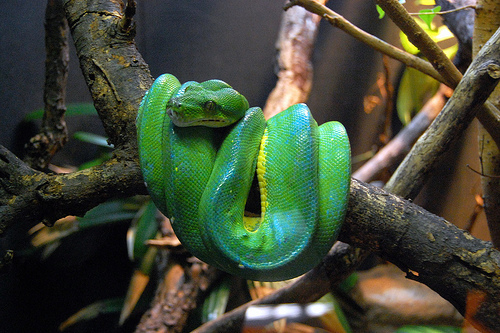

In [1440]:
im

In [1441]:
# .crop((0,0,500,316))
temp_im = im
temp_im = temp_im.resize((512, 512))

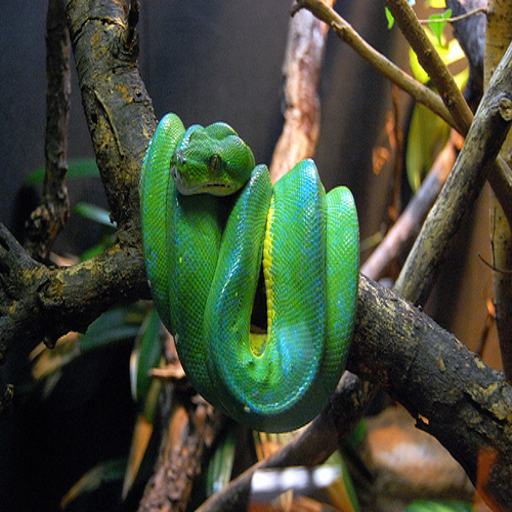

In [1442]:

temp_im

In [1443]:
inputfile = "single_view_mpi/temp_image.png"

temp_im.save(inputfile)

# Generate MPI

input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
layers = model(input_rgb[tf.newaxis])[0]
depths = mpi.make_depths(1.0, 100.0, 32).numpy()

In [1444]:
# Rendering Code

reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
    target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
    image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=512)
    return image

In [1445]:
# def center_crop_img(img,)

In [1446]:
# Load ImageNet prediction code

transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),  
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

with open('../training_models/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

imagenet_model = models.resnet18(pretrained=True)
imagenet_model.eval();

def predict_from_rendered(rendered, show = True, return_val = False):
    rendered_img = Image.fromarray((np.array(rendered)*255).astype('uint8'))

    img_t = transform(rendered_img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = imagenet_model(batch_t)

    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred_idx = indices[0][:1].item()
    title = "Class:%s, Confidence:%0.02f"%(classes[pred_idx], percentage[pred_idx].item()/100)

    if show:
        rendered_resized = rendered_img.resize((256, 256))
        center_cropped = rendered_resized.crop((16,16,240,240))
        plt.imshow(center_cropped)
        plt.title(title)
        plt.axis('off')
        plt.show()
    if return_val:
        return pred_idx, percentage[pred_idx].item()/100

In [1447]:
def objective(offsets, show = False):
    rendered_img = render(offsets[0], offsets[1], offsets[2])
    pred_id, percent = predict_from_rendered(rendered_img, False, True)
    if show == True:
        plt.imshow(rendered_img)
        plt.title('Pred:%s'%pred_id)
        plt.axis('off')
    return percent, pred_id

# Set up CMA-ES attack

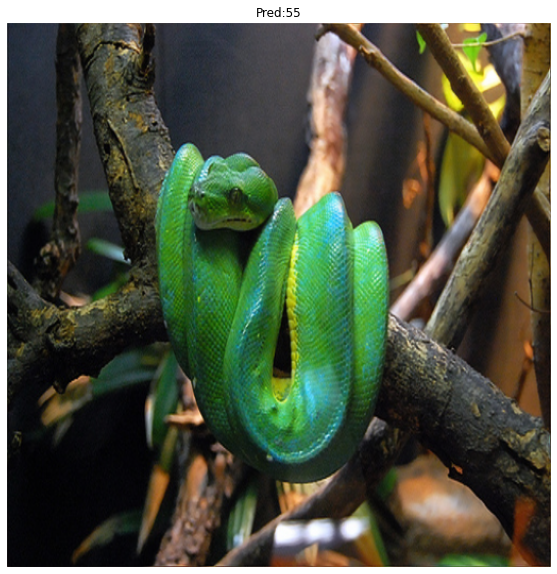

In [1448]:
gt_prob, gt_cat = objective(np.array([0,0,0]), True)

In [1429]:
### import cma 
start_pos = np.array([0,0,0])
es = cma.CMAEvolutionStrategy(start_pos, 0.005)

es.optimize(objective, verb_disp = True, iterations=5, correct_prediction = gt_cat)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=942393, Mon May 24 21:00:45 2021)
Predictions are :[764, 764, 764, 764, 764, 764, 764]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 5.918821716308593e-01 1.0e+00 4.82e-03  5e-03  5e-03 0:03.8
Adversarial found, should stop now.
Adversarial found, should stop now.
Predictions are :[764, 764, 764, 764, 764, 558, 558]
    2     14 3.999618530273438e-01 1.3e+00 5.80e-03  5e-03  6e-03 0:07.5
Adversarial found, trying to stop.
    2     14 3.999618530273438e-01 1.3e+00 5.80e-03  5e-03  6e-03 0:07.5
termination by {}
best f-value = 0.39996185302734377
solution = [-0.0057551  -0.00695815 -0.00406075]


In [1430]:
errored_indexes = [i for i in range(len(es.predictions)) if es.predictions[i] != gt_cat]

In [1431]:
errored_settings = [es.prediction_settings[i] for i in errored_indexes]

In [1432]:
# errored_settings

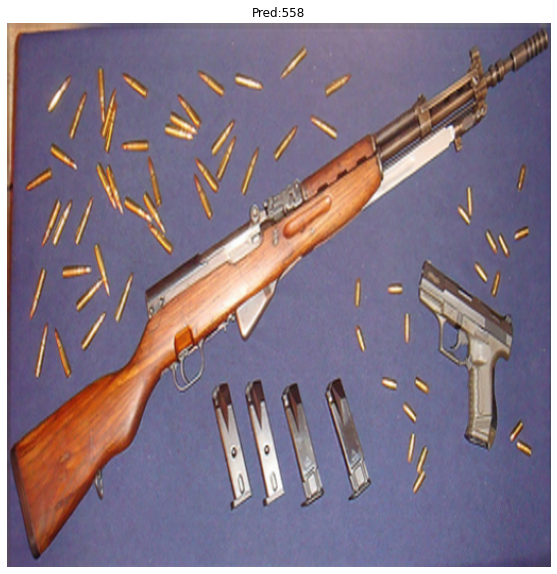

In [1433]:
for er in errored_settings:
    objective(er, True)